# Ensemble Trees Prediction model of production rate 

#### Zihao Zhao
####  Hildebrand Department of Petroleum and Geosystems Engineering, Cockrell School of Engineering

### Subsurface Machine Learning Course, The University of Texas at Austin
#### Hildebrand Department of Petroleum and Geosystems Engineering, Cockrell School of Engineering
#### Department of Geological Sciences, Jackson School of Geosciences

Workflow supervision and review by:

#### Instructor: Prof. Michael Pyrcz, Ph.D., P.Eng., Associate Professor, The Univeristy of Texas at Austin
##### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Course TA: Jack Xiao, Graduate Student, The University of Texas at Austin
##### [Twitter](https://twitter.com/jackxiao6) | [LinkedIn](https://www.linkedin.com/in/yuchen-jack-xiao-b1b20876/)

### Executive Summary

Reservoir simulation is a common tool to quantify the production forecasting uncertainty, inherits several uncertainties of geological model (e.g., structure and stratigraphy), reservoir properties (e.g., porosity and permeability fields), and fluid properties. Despite the current computer advancement, efficient simulation are still challenging because of two competing aspects: accuracy and computational cost. 

The aim of this project is to build up an accurate regression model for production rate based on physical propies such as permeability and porosity. To start with, All data were checked and filtered to make sure every data in this research satisfy physical requirement. Then Feature ranking including Bivariate Distribution,Pairwise Correlation Coefficient,Partial Correlation Coefficient calculation are conducted to check the intercorrelation and importance between different features.Ensemble tree analysis is conducted to estabilish the regression model for production rate. Tree bagging and random forest are both conducted to improve the model performance in testing data.

Originally, I planned to use ANN for prediction. However, my GPU is made by AMD and the website indicates that the process to build the working environment for Tensorflow package is too complex for AMD (I need to install Ubuntu and ROCm) and the compatibility is not as good as Nvidia GPU. I gave up my original plan and applied Ensemble tree instead.The workflow could be more advanced by incorporate ANN model and MCMC algorithm, which provided posterior distribution rather than one average value. An iterative workflow can increase the model performance as well. Besides, to build an accurate model, more data such as water saturation, BHP can also be helpful.



In [1]:
### Import Packages
import numpy as np                        # for working with data and model arrays
import pandas as pd                       # DataFrames package
import os                                 # set working directory, run executables
import matplotlib.pyplot as plt           # for plotting
from scipy import stats                   # statistics
import math                               
import scipy.signal as signal             # kernel for moving window calculation
import random
import seaborn as sns              # summary statistics
from scipy import linalg                  # for linear regression
from sklearn.feature_selection import RFE # for recursive feature selection
from sklearn.linear_model import LinearRegression # linear regression model                                             # to set current working directory 
from sklearn.preprocessing import StandardScaler          # standardize variables to mean of 0.0 and variance of 1.0                                      # DataFrames and plotting
import pandas.plotting as pd_plot                         # matrix scatter plots
import geostatspy.GSLIB as GSLIB          # GSLIB utilies, visualization and wrapper
import geostatspy.geostats as geostats    # GSLIB methods convert to Python       
import os                                                   # to set current working directory 
import math                                                 # basic calculations like square root
from sklearn import tree                                    # tree program from scikit learn (package for machine learning)
from sklearn.tree import _tree                              # for accessing tree information
from sklearn import metrics                                 # measures to check our models
from sklearn.tree import export_graphviz                    # graphical visualization of trees
from sklearn.preprocessing import StandardScaler            # standardize variables to mean of 0.0 and variance of 1.0

from sklearn.model_selection import cross_val_score         # cross validation methods
from sklearn.tree import DecisionTreeRegressor              # decision tree method
from sklearn import model_selection
from sklearn.ensemble import BaggingRegressor               # bagging tree method
from sklearn.ensemble import RandomForestRegressor          # random forest method
                                        # DataFrames and plotting
import pandas.plotting as pd_plot
from subprocess import check_call

from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor


The following code block is from Professor Michael Pyrcz (@GeostatsGuy）

In [2]:
def partial_corr(C):
#    Returns the sample linear partial correlation coefficients between pairs of variables in C, controlling 
#    for the remaining variables in C.

#    Parameters
#    C : array-like, shape (n, p)
#        Array with the different variables. Each column of C is taken as a variable
#    Returns
#    P : array-like, shape (p, p)
#        P[i, j] contains the partial correlation of C[:, i] and C[:, j] controlling
#        for the remaining variables in C.

    C = np.asarray(C)
    p = C.shape[1]
    P_corr = np.zeros((p, p), dtype=np.float)
    for i in range(p):
        P_corr[i, i] = 1
        for j in range(i+1, p):
            idx = np.ones(p, dtype=np.bool)
            idx[i] = False
            idx[j] = False
            beta_i = linalg.lstsq(C[:, idx], C[:, j])[0]
            beta_j = linalg.lstsq(C[:, idx], C[:, i])[0]
            res_j = C[:, j] - C[:, idx].dot( beta_i)
            res_i = C[:, i] - C[:, idx].dot(beta_j)
            corr = stats.pearsonr(res_i, res_j)[0]
            P_corr[i, j] = corr
            P_corr[j, i] = corr
    return P_corr

def semipartial_corr(C): # Michael Pyrcz modified the function above by Fabian Pedregosa-Izquierdo, f@bianp.net for semipartial correlation
    C = np.asarray(C)
    p = C.shape[1]
    P_corr = np.zeros((p, p), dtype=np.float)
    for i in range(p):
        P_corr[i, i] = 1
        for j in range(i+1, p):
            idx = np.ones(p, dtype=np.bool)
            idx[i] = False
            idx[j] = False
            beta_i = linalg.lstsq(C[:, idx], C[:, j])[0]
            res_j = C[:, j] - C[:, idx].dot( beta_i)
            res_i = C[:, i] # just use the value, not a residual
            corr = stats.pearsonr(res_i, res_j)[0]
            P_corr[i, j] = corr
            P_corr[j, i] = corr
    return P_corr
def plot_corr(dataframe,size=10):                         # plots a graphical correlation matrix 
    corr = dataframe.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    im = ax.matshow(corr,vmin = -1.0, vmax = 1.0)
    plt.xticks(range(len(corr.columns)), corr.columns);
    plt.yticks(range(len(corr.columns)), corr.columns);
    plt.colorbar(im, orientation = 'vertical')
    plt.title('Correlation Matrix')
    
    
    
def plot_corr(dataframe,size=10):                           # plots a graphical correlation matrix 
    corr = dataframe.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    im = ax.matshow(corr,vmin = -1.0, vmax = 1.0)
    plt.xticks(range(len(corr.columns)), corr.columns);
    plt.yticks(range(len(corr.columns)), corr.columns);
    plt.colorbar(im, orientation = 'vertical')
    plt.title('Correlation Matrix')
    
def visualize_model(model,xfeature,x_min,x_max,yfeature,y_min,y_max,response,z_min,z_max,title,):# plots the data points and the decision tree prediction 
    n_classes = 10
    cmap = plt.cm.RdYlBu
    plot_step = 0.02
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                     np.arange(y_min, y_max, plot_step))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=cmap,vmin=z_min, vmax=z_max, levels=np.linspace(z_min, z_max, 100))

    im = plt.scatter(xfeature,yfeature,s=None, c=response, marker=None, cmap=cmap, norm=None, vmin=z_min, vmax=z_max, alpha=0.8, linewidths=0.3, verts=None, edgecolors="black")
    plt.title(title)
    plt.xlabel(xfeature.name)
    plt.ylabel(yfeature.name)
    cbar = plt.colorbar(im, orientation = 'vertical')
    cbar.set_label(response.name, rotation=270, labelpad=20)
    return Z

def visualize_grid(Z,xfeature,x_min,x_max,yfeature,y_min,y_max,response,z_min,z_max,title,):# plots the data points and the decision tree prediction 
    n_classes = 10
    cmap = plt.cm.RdYlBu
    plot_step = 0.02
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                     np.arange(y_min, y_max, plot_step))
    cs = plt.contourf(xx, yy, Z, cmap=cmap,vmin=z_min, vmax=z_max, levels=np.linspace(z_min, z_max, 100))

    im = plt.scatter(xfeature,yfeature,s=None, c=response, marker=None, cmap=cmap, norm=None, vmin=z_min, vmax=z_max, alpha=0.8, linewidths=0.3, verts=None, edgecolors="black")
    plt.title(title)
    plt.xlabel(xfeature.name)
    plt.ylabel(yfeature.name)
    cbar = plt.colorbar(im, orientation = 'vertical')
    cbar.set_label(response.name, rotation=270, labelpad=20)
    
def check_model(model,xfeature,yfeature,response,title):    # plots the estimated vs. the actual  
    predict_train = model.predict(np.c_[xfeature,yfeature])
    plt.scatter(response,predict_train,s=None, c='red',marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.2, linewidths=0.3, verts=None, edgecolors="black")
    plt.title(title); plt.xlabel('Actual Production (MCFPD)'); plt.ylabel('Estimated Production (MCFPD)')
    plt.xlim(0,7000); plt.ylim(0,7000)
    plt.arrow(0,0,7000,7000,width=0.02,color='black',head_length=0.0,head_width=0.0)
    MSE = metrics.mean_squared_error(response,predict_train)
    Var_Explained = metrics.explained_variance_score(response,predict_train)
    cor = math.sqrt(metrics.r2_score(response,predict_train))
    print('Mean Squared Error on Training = ', round(MSE,2),', Variance Explained =', round(Var_Explained,2),'Cor =', round(cor,2))

def feature_sample(array, xmin, ymin, xstep, ystep, df_x, df_y, name): # sampling predictions from a feature space grid 

    if array.ndim != 2:
        raise ValueError("Array must be 2D")

    if len(df_x) != len(df_y):
        raise ValueError("x and y feature arrays must have equal lengths")
        
    ny, nx = array.shape
    df = pd.DataFrame()
    v = []
    nsamp = len(df_x)
    for isamp in range(nsamp):
        x = df_x.iloc[isamp]
        y = df_y.iloc[isamp]
        iy = min(ny - int((y - ymin) / ystep) - 1, ny - 1)
        ix = min(int((x - xmin) / xstep), nx - 1)
        v.append(array[iy, ix])
    df[name] = v
    return df    
    
def check_grid(grid,xmin,xmax,ymin,ymax,xfeature,yfeature,response,title):    # plots the estimated vs. the actual  
    if grid.ndim != 2:
        raise ValueError("Prediction array must be 2D")
    ny, nx = grid.shape
    xstep = (xmax - xmin)/nx; ystep = (ymax-ymin)/ny 
    #predict_train = model.predict(np.c_[xfeature,yfeature])
    predict_train = feature_sample(grid, xmin, ymin, xstep, ystep, xfeature, yfeature, 'sample')
    plt.scatter(response,predict_train,s=None, c='red',marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.2, linewidths=0.3, verts=None, edgecolors="black")
    plt.title(title); plt.xlabel('Actual Production (MCFPD)'); plt.ylabel('Estimated Production (MCFPD)')
    plt.xlim(0,7000); plt.ylim(0,7000)
    plt.arrow(0,0,7000,7000,width=0.02,color='black',head_length=0.0,head_width=0.0)
    MSE = metrics.mean_squared_error(response,predict_train)
    Var_Explained = metrics.explained_variance_score(response,predict_train)
    cor = math.sqrt(metrics.r2_score(response,predict_train))
    print('Mean Squared Error on Training = ', round(MSE,2),', Variance Explained =', round(Var_Explained,2),'Cor =', round(cor,2))

## Step 1 Data Preparation
### 1.1 Load Data
To start with, we first load the data into dataframe. This project applies the .csv file 'unconv_MV_v5.csv'
The features are listed and explained as follows：
* **por** - fraction of rock void in units of percentage
* **Perm** - ability of a fluid to flow through the rock in mil;iDarcy
* **AI** - product of sonic velocity
* **Brittleness**
* **TOC** -tatal oil contained

For convinience, I also changed the operation direction/

In [3]:
os.chdir(r"C:\Users\Zihao\Desktop\ML")             

In [4]:
df = pd.read_csv('unconv_MV_v5.csv')     

### 1.2 Basic Data Checking and Visualization
Let's first start from data checking, we first check the first five row of the data

In [5]:
print(df.iloc[0:5,:])                   
#df.head(n=13)                           

   Well    Por  Perm    AI  Brittle   TOC    VR         Prod
0     1  12.08  2.92  2.80    81.40  1.16  2.31  4165.196191
1     2  12.38  3.53  3.22    46.17  0.89  1.88  3561.146205
2     3  14.02  2.59  4.01    72.80  0.89  2.72  4284.348574
3     4  17.67  6.75  2.63    39.81  1.08  1.88  5098.680869
4     5  17.52  4.57  3.18    10.94  1.51  1.90  3406.132832


The data summary is as follows

In [6]:
df.describe()

,Well,Por,Perm,AI,Brittle,TOC,VR,Prod
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,100.500000,14.991150,4.330750,2.968850,48.161950,0.990450,1.964300,4311.219852
std,57.879185,2.971176,1.731014,0.566885,14.129455,0.481588,0.300827,992.038414
min,1.000000,6.550000,1.130000,1.280000,10.940000,-0.190000,0.930000,2107.139414
25%,50.750000,12.912500,3.122500,2.547500,37.755000,0.617500,1.770000,3618.064513
50%,100.500000,15.070000,4.035000,2.955000,49.510000,1.030000,1.960000,4284.687348
75%,150.250000,17.402500,5.287500,3.345000,58.262500,1.350000,2.142500,5086.089761
max,200.000000,23.550000,9.870000,4.630000,84.330000,2.180000,2.870000,6662.622385


As can be seen from the above summary, part of TOC data is below 0. It is physically impossible. The minimum should be 0 at least. So we need to replace those values by 0. Other data are acturally pretty good

Next we check the histograms to see the distribution of each feature

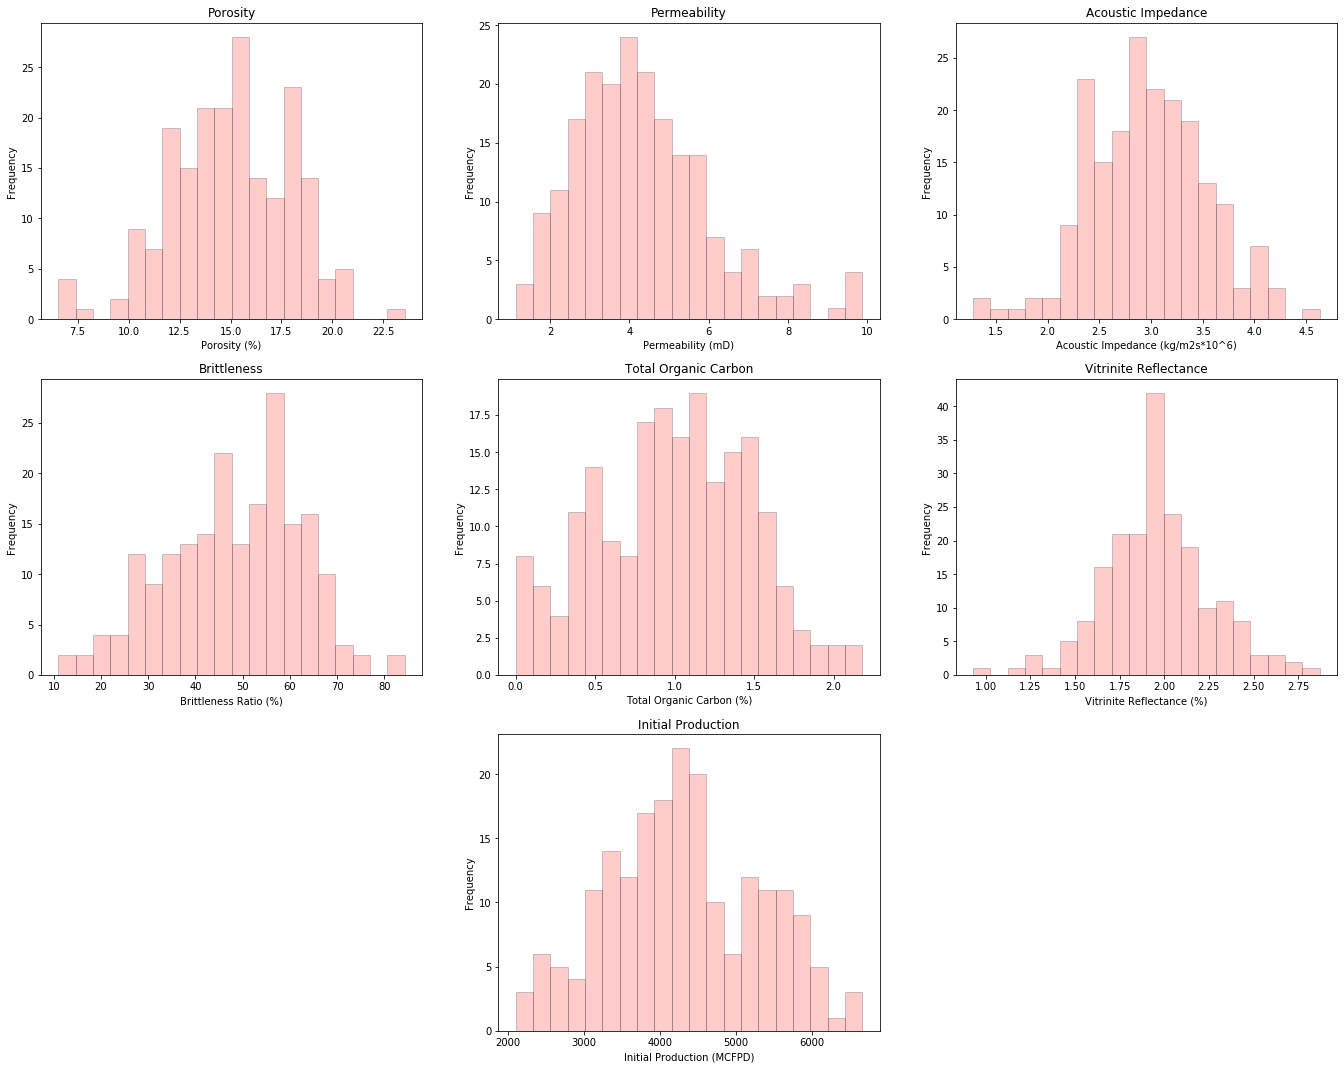

In [7]:
df['TOC'] = np.where(df['TOC']<0.0, 0.0, df['TOC']) 
pormin = min(df['Por']); pormax = max(df['Por']); 
porname = 'Porosity (%)'; portitle = 'Porosity' 
permmin = min(df['Perm']); permmax = max(df['Perm']);
permname = 'Permeability (mD)'; permtitle = 'Permeability'     
AImin = min(df['AI']); AImax = max(df['AI']);
AIname = 'Acoustic Impedance (kg/m2s*10^6)'; AItitle = 'Acoustic Impedance'
brmin = min(df['Brittle']); brmax = max(df['Brittle']);
brname = 'Brittleness Ratio (%)'; brtitle = 'Brittleness'
TOCmin = min(df['TOC']); TOCmax = max(df['TOC']);
TOCname = 'Total Organic Carbon (%)'; TOCtitle = 'Total Organic Carbon' 
VRmin = min(df['VR']); VRmax = max(df['VR']);
VRname = 'Vitrinite Reflectance (%)'; VRtitle = 'Vitrinite Reflectance'
prodmin = min(df['Prod']); prodmax = max(df['Prod']);
prodname = 'Initial Production (MCFPD)'; prodtitle = 'Initial Production'
    
plt.subplot(331)
GSLIB.hist_st(df['Por'].values,pormin,pormax,log=False,cumul = False,bins=20,weights = None,xlabel=porname,title=portitle)
plt.subplot(332)
GSLIB.hist_st(df['Perm'].values,permmin,permmax,log=False,cumul = False,bins=20,weights = None,xlabel=permname,title=permtitle)
plt.subplot(333)
GSLIB.hist_st(df['AI'].values,AImin,AImax,log=False,cumul = False,bins=20,weights = None,xlabel=AIname,title=AItitle)
plt.subplot(334)
GSLIB.hist_st(df['Brittle'].values,brmin,brmax,log=False,cumul = False,bins=20,weights = None,xlabel=brname,title=brtitle)
plt.subplot(335)
GSLIB.hist_st(df['TOC'].values,TOCmin,TOCmax,log=False,cumul = False,bins=20,weights = None,xlabel=TOCname,title=TOCtitle)
plt.subplot(336)
GSLIB.hist_st(df['VR'].values,VRmin,VRmax,log=False,cumul = False,bins=20,weights = None,xlabel=VRname,title=VRtitle)
plt.subplot(338)
GSLIB.hist_st(df['Prod'].values,prodmin,prodmax,log=False,cumul = False,bins=20,weights = None,xlabel=prodname,title=prodtitle)
plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=3.5, wspace=0.2, hspace=0.2)
plt.show()

## Step 2 Feature ranking

In this data, we have many parameters such as Porosity, Permeability, Acpustic Impedence, Brittleness and TOC.  Choosing too much parameters will not only increases the calculation time, risk of blunders, but also adds more difficulty for visualization and so on. Thus, to be selective in the prediction features is of vital importance. 


### 2.1 Bivariate Distribution
I first start with simplest Bivariate distribution,

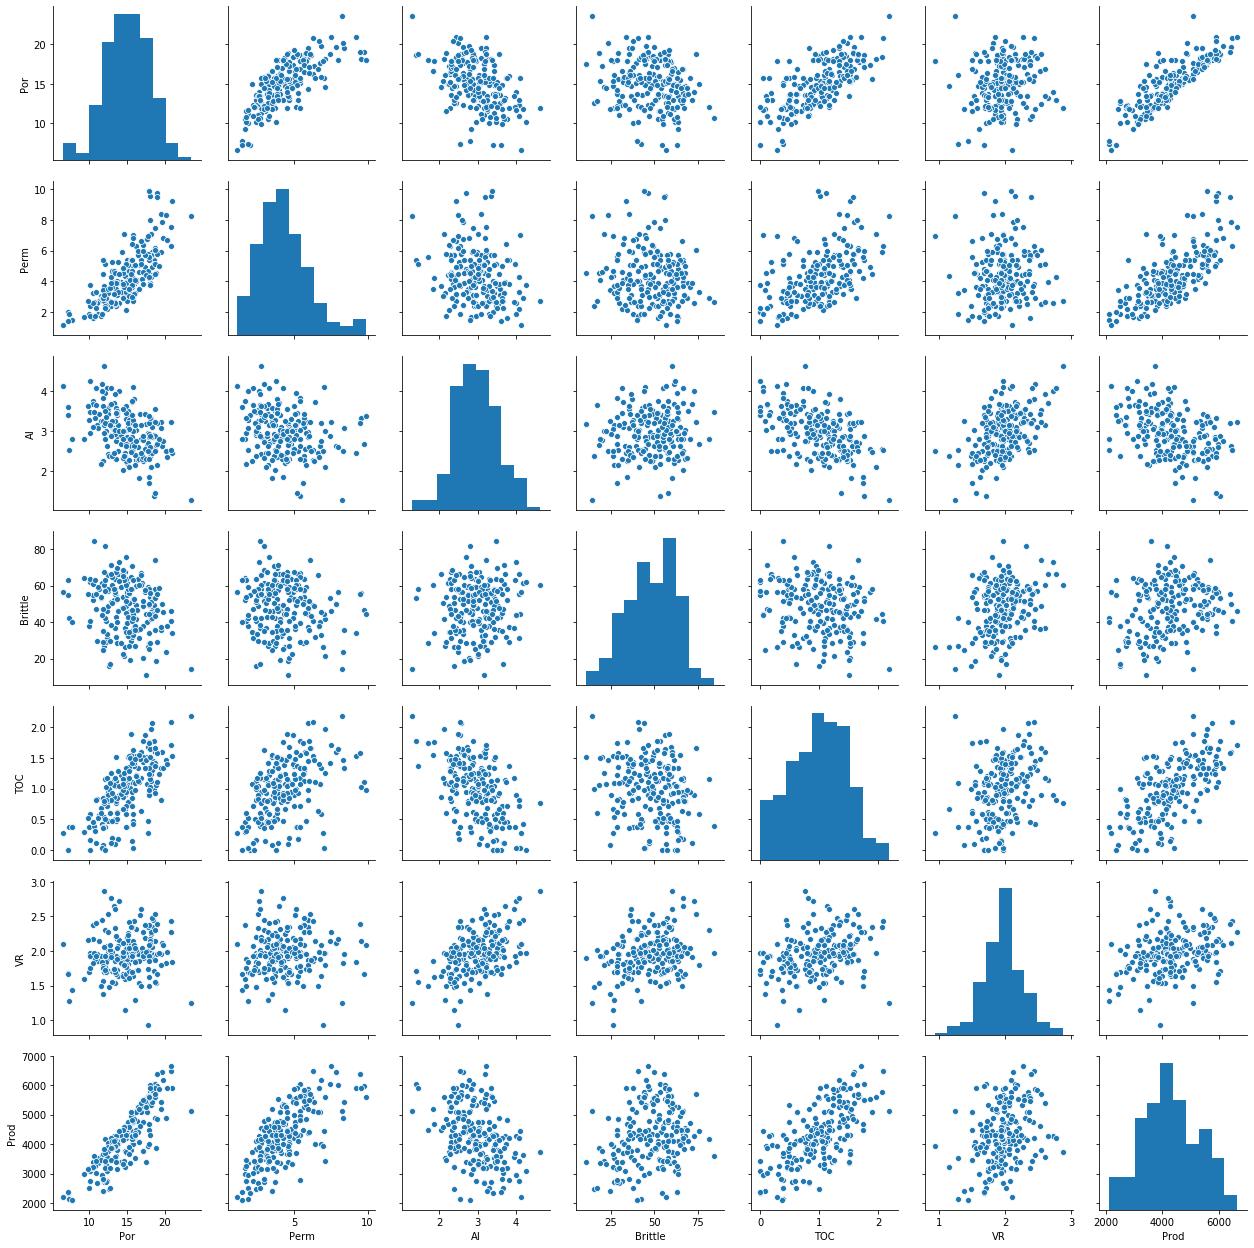

In [8]:
sns.pairplot(df,vars=['Por','Perm','AI','Brittle','TOC','VR','Prod'],markers='o')

As can be seen from the above graph, porosity, permeability and TOC has strong collinearity. Porosity and permeability are highly correlated. Porosity and TOC are also somewhat related. These result all matches physical phenomenon.

### 2.2 Pairwise Correlation Coefficient
Pairwise correlation coefficient provides a measure of the strength of the linear relationship between each predictor feature and the response feature.

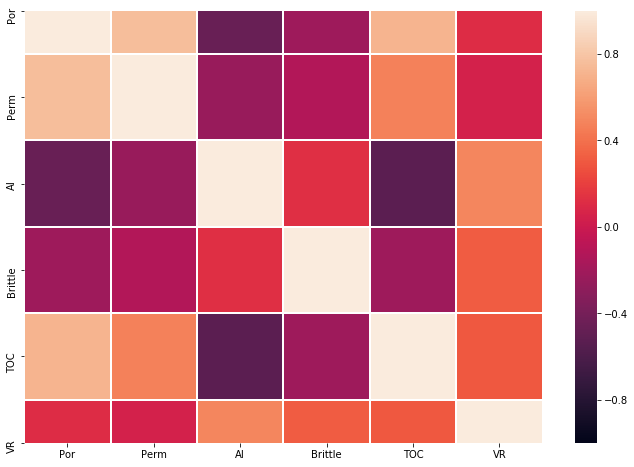

In [9]:
plt.subplot(111)                          
sns.heatmap(df.iloc[:,1:7].corr(),vmin = -1.0, vmax = 1.0,linewidths=1, )
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.5, top=1.5, wspace=0.2, hspace=0.2)
plt.show()

As can be seen from above, we can reach the following conclusion that
* permeability and porosity are strongly correlated
* AI and TOC are strongly inversely correlated 
* AI and Brittleness have no correlation at all
* Porosity and VR have no correlation at all

### 2.3 Partial Correlation Coefficient with standarized data
The rank correlation coefficient applies the rank transform to the data prior to calculating the correlation coefficent.
I realized that partial correlation coefficient can be very deceiving if we don't do standarization in advance. So I first standarized all the data.

In [10]:

dfS = pd.DataFrame()                    
dfS['Well'] = df['Well'].values
dfS['Por'] = GSLIB.affine(df['Por'].values,0.0,1.0)
dfS['Perm'] = GSLIB.affine(df['Perm'].values,0.0,1.0)
dfS['AI'] = GSLIB.affine(df['AI'].values,0.0,1.0)
dfS['Brittle'] = GSLIB.affine(df['Brittle'].values,0.0,1.0)
dfS['TOC'] = GSLIB.affine(df['TOC'].values,0.0,1.0)
dfS['VR'] = GSLIB.affine(df['VR'].values,0.0,1.0)
dfS['Prod'] = GSLIB.affine(df['Prod'].values,0.0,1.0)



dfS = pd.DataFrame()                      
dfS['Well'] = df['Well'].values
dfS['Por'],d1,d2 = geostats.nscore(df,'Por')
dfS['Perm'],d1,d2 = geostats.nscore(df,'Perm')
dfS['AI'],d1,d2 = geostats.nscore(df,'AI')
dfS['Brittle'],d1,d2 = geostats.nscore(df,'Brittle')
dfS['TOC'],d1,d2 = geostats.nscore(df,'TOC')
dfS['VR'],d1,d2 = geostats.nscore(df,'VR')
dfS['Prod'],d1,d2 = geostats.nscore(df,'Prod')
dfS.head()

,Well,Por,Perm,AI,Brittle,TOC,VR,Prod
0,1,-0.964092,-0.780664,-0.285841,2.432379,0.312053,1.114651,-0.106734
1,2,-0.832725,-0.378580,0.446827,-0.195502,-0.272809,-0.325239,-0.730638
2,3,-0.312053,-1.069155,1.722384,2.004654,-0.272809,2.241403,-0.006267
3,4,0.730638,1.325516,-0.531604,-0.590284,0.131980,-0.325239,0.698283
4,5,0.698283,0.298921,0.365149,-2.870033,1.047216,-0.259823,-0.905879


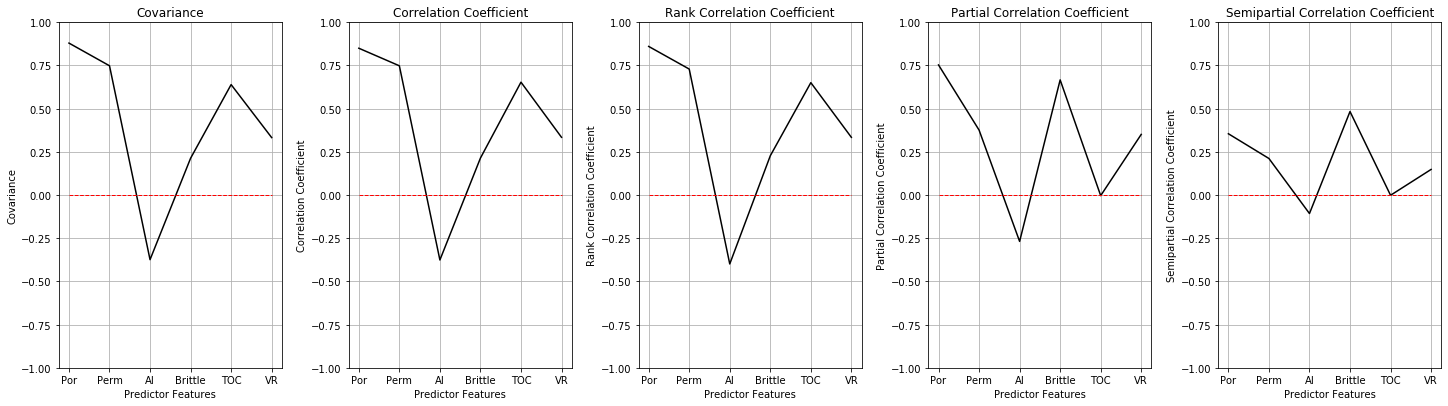

In [11]:
partial_correlation = partial_corr(df.iloc[:,1:8]) 
partial_correlation = partial_correlation[:,6][:6] 
stand_covariance = dfS.iloc[:,1:8].cov().iloc[6,:6]
stand_correlation = dfS.iloc[:,1:8].corr().iloc[6,:6]
stand_rank_correlation, stand_rank_correlation_pval = stats.spearmanr(dfS.iloc[:,1:8])
stand_rank_correlation = stand_rank_correlation[:,6][:6]
stand_rank_correlation_pval = stand_rank_correlation_pval[:,6][:6]
stand_partial_correlation = partial_corr(dfS.iloc[:,1:8])
stand_partial_correlation = stand_partial_correlation[:,6][:6]
stand_semipartial_correlation = semipartial_corr(dfS.iloc[:,1:8])
stand_semipartial_correlation = stand_semipartial_correlation[:,6][:6]
features = df.columns.values[1:][:6]
plt.subplot(151)
plt.plot(features,stand_covariance,color='black')
plt.plot([0.0,0.0,0.0,0.0,0.0,0.0],'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features')
plt.ylabel('Covariance')
t = plt.title('Covariance')
plt.ylim(-1,1)
plt.grid(True)

plt.subplot(152)
plt.plot(features,stand_correlation,color='black')
plt.plot([0.0,0.0,0.0,0.0,0.0,0.0],'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features')
plt.ylabel('Correlation Coefficient')
t = plt.title('Correlation Coefficient')
plt.ylim(-1,1)
plt.grid(True)

plt.subplot(153)
plt.plot(features,stand_rank_correlation,color='black')
plt.plot([0.0,0.0,0.0,0.0,0.0,0.0],'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features')
plt.ylabel('Rank Correlation Coefficient')
t = plt.title('Rank Correlation Coefficient')
plt.ylim(-1,1)
plt.grid(True)

plt.subplot(154)
plt.plot(features,stand_partial_correlation,color='black')
plt.plot([0.0,0.0,0.0,0.0,0.0,0.0],'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features')
plt.ylabel('Partial Correlation Coefficient')
t = plt.title('Partial Correlation Coefficient')
plt.ylim(-1,1)
plt.grid(True)

plt.subplot(155)
plt.plot(features,stand_semipartial_correlation,color='black')
plt.plot([0.0,0.0,0.0,0.0,0.0,0.0],'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features')
plt.ylabel('Semipartial Correlation Coefficient')
t = plt.title('Semipartial Correlation Coefficient')
plt.ylim(-1,1)
plt.grid(True)

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.2, top=1.2, wspace=0.3, hspace=0.2)
plt.show()



As can be seen from the above graphs, we can get the following conclusion:
* Based on Covariance and Correlation Coefficient, porosity and permeability are the most important parameters, while AI and TOC is 
* Unlike covariance, partial correlation coefficient indicates that permeability  is not that important, this is due to the fact that porosity and permeability is strongly correlated. So there contribution are shared after we do partial correlation analysis.
* TOC has little contribute to the result after analsis.


### 2.4 Mutual Information

Feature ranking:
1. feature Por = 1.000000
2. feature Perm = 0.462871
3. feature TOC = 0.253973
4. feature Brittle = 0.081044
5. feature VR = 0.078861
6. feature AI = 0.047881


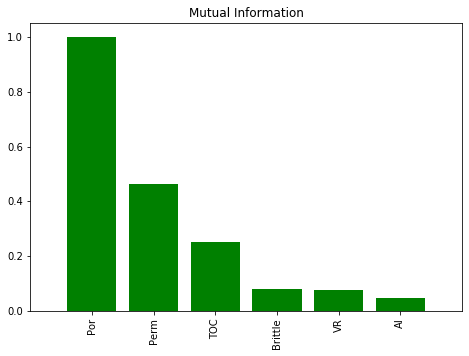

In [12]:
#Mutual Information
from sklearn.feature_selection import mutual_info_regression

x = df.iloc[:,[1,2,3,4,5,6]]              
y = df.iloc[:,[7]]

mi = mutual_info_regression(x,np.ravel(y)) 
mi /= np.max(mi)                          

indices = np.argsort(mi)[::-1]            

print("Feature ranking:")                 
for f in range(x.shape[1]):
    print("%d. feature %s = %f" % (f + 1, x.columns[indices][f], mi[indices[f]]))

plt.subplot(111)                          
plt.title("Mutual Information")
plt.bar(range(x.shape[1]), mi[indices],
       color="g", align="center")
plt.xticks(range(x.shape[1]), x.columns[indices],rotation=90)
plt.xlim([-1, x.shape[1]])
plt.subplots_adjust(left=0.0, bottom=0.0, right=1., top=1., wspace=0.2, hspace=0.2)
plt.show()


From mutual information we can observe that porosity, permeability then TOC ann brittleness have the greatest departure from general independence.

### 2.5 Conclusion
From the above analysis, I decided to chose Porosity and Permeability as the predictor features for the following reason:
* VR is never considered to be a very influencial parameter in above analysis
* TOC and AI are strongly negtively correlated. However, from partial correlated coefficient, TOC has no contribute for production ate at all, so I give up these two parameters.
* In every analysis, porosity and permeability are considered to be very important 



## 3. EnsembleTrees

The goal of ensemble methods is to combine the predictions of several base estimators built with a given learning algorithm in order to improve generalizability / robustness over a single estimator.For unconv_MV_v5, there is only 250 data in total. In order to have more test data, I didn't exactly follow the rule taught in class. I extracted 100 samples for test, and rest 150 data used to do training.

In [13]:
my_data_test = df.iloc[100:,1:8]                    
my_data = df.iloc[0:100,1:8]                         
my_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Por,100.0,14.692500,2.813265,7.270000,12.602500,14.790000,16.670000,20.960000
Perm,100.0,4.182300,1.617741,1.620000,3.007500,3.920000,5.140000,9.210000
AI,100.0,2.978900,0.564870,1.390000,2.547500,2.925000,3.352500,4.630000
Brittle,100.0,49.564900,13.986114,10.940000,40.442500,50.485000,59.305000,84.330000
TOC,100.0,0.962500,0.439911,0.000000,0.712500,0.960000,1.225000,2.070000
VR,100.0,1.975400,0.304337,1.150000,1.800000,1.970000,2.142500,2.870000
Prod,100.0,4271.444429,970.615931,2119.315516,3618.064513,4230.044477,5003.654659,6455.048131


In [14]:
  
pormin = 5.0; pormax = 25.0 
permin =0; permax = 10
prodmin = 0.0; prodmax = 13000.0
my_data_subset = my_data.iloc[:,[0,1,4,6]]                    
my_data_test_subset = my_data_test.iloc[:,[0,1,4,6]]          
  

### 3.1 Tree Bagging Regression

In ensemble algorithms, bagging methods form a class of algorithms which build several instances of a black-box estimator on random subsets of the original training set and then aggregate their individual predictions to form a final prediction.To perform tree bagging, the hyperparameters for the individual trees are set as follow:

* seed = 73073
* max_depth = 100
* min_samples_leaf = 2 
* num_trees = 100



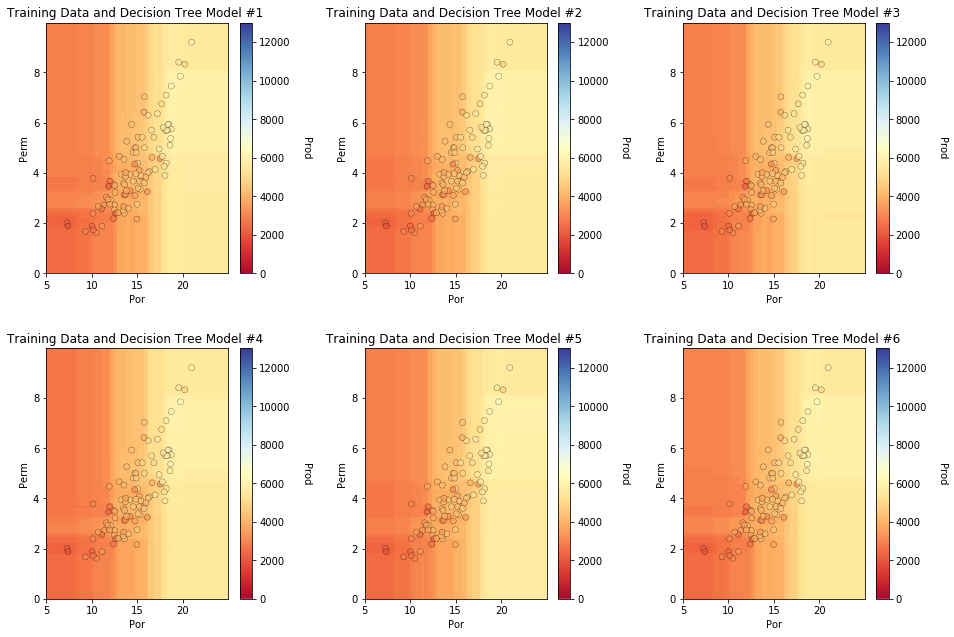

In [15]:
predictors = my_data_subset[['Por','Perm']].copy()       
response = my_data_subset[['Prod']].copy()            
predictors_test = my_data_test_subset[['Por','Perm']].copy() 
response_test = my_data_test_subset[['Prod']].copy()  
import warnings
warnings.filterwarnings('ignore')                          

max_depth = 100; min_samples_leaf = 2                       

regressor = DecisionTreeRegressor(max_depth = max_depth, min_samples_leaf = min_samples_leaf) 

num_tree = 100                                               
seeds = [73073, 73074, 73075, 73076, 73077, 73078]
bagging_models = []; oob_MSE = []; score = []; pred = []

index = 1
for seed in seeds:                                          
    bagging_models.append(BaggingRegressor(base_estimator=regressor, n_estimators=num_tree, random_state=seed, oob_score = True, n_jobs = 4))
    bagging_models[index-1].fit(X = predictors, y = response)
    oob_MSE.append(bagging_models[index-1].oob_score_)
    score.append(bagging_models[index-1].score(X = predictors_test, y = response_test))
    plt.subplot(2,3,index)
    pred.append(visualize_model(bagging_models[index-1],my_data_subset["Por"],pormin,pormax,my_data_subset["Perm"],permin,permax,my_data_subset["Prod"],prodmin,prodmax,'Training Data and Decision Tree Model #' + str(index) + ' '))
    index = index + 1
    
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.0, wspace=0.4, hspace=0.3)

Check the cross validation results with the withheld testing dat

Mean Squared Error on Training =  320118.61 , Variance Explained = 0.7 Cor = 0.83
Mean Squared Error on Training =  315152.26 , Variance Explained = 0.7 Cor = 0.83
Mean Squared Error on Training =  314807.76 , Variance Explained = 0.7 Cor = 0.83
Mean Squared Error on Training =  309761.08 , Variance Explained = 0.71 Cor = 0.83
Mean Squared Error on Training =  308069.88 , Variance Explained = 0.71 Cor = 0.84
Mean Squared Error on Training =  307750.0 , Variance Explained = 0.71 Cor = 0.84


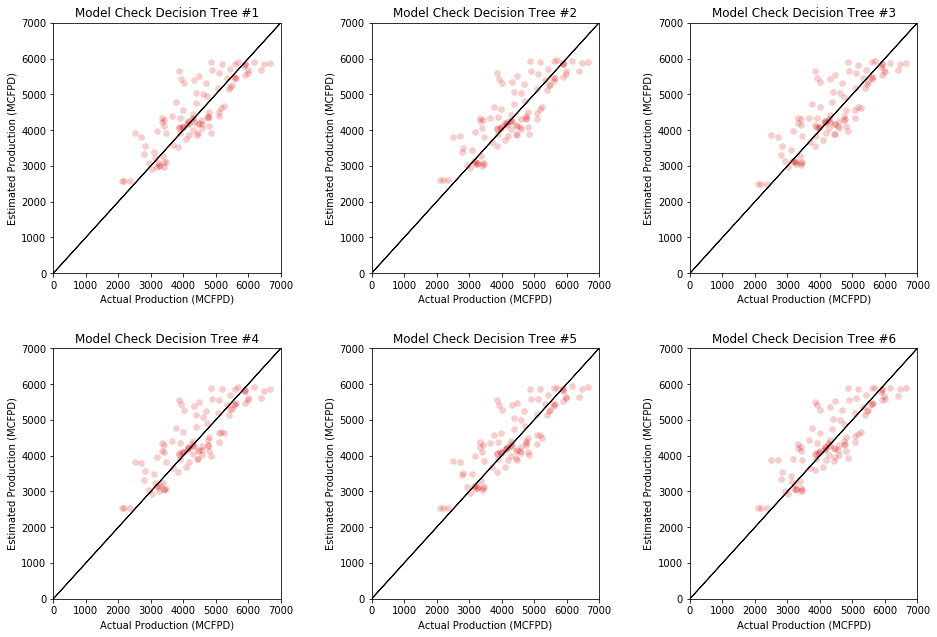

In [16]:
index = 1
for seed in seeds:                                          
    plt.subplot(2,3,index)
    check_model(bagging_models[index-1],my_data_test_subset["Por"],my_data_test_subset["Perm"],my_data_test_subset["Prod"],'Model Check Decision Tree #' + str(index))
    index = index + 1
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.0, wspace=0.4, hspace=0.3)

we average the prediction over the decision trees:

Mean Squared Error on Training =  361926.99 , Variance Explained = 0.68 Cor = 0.8


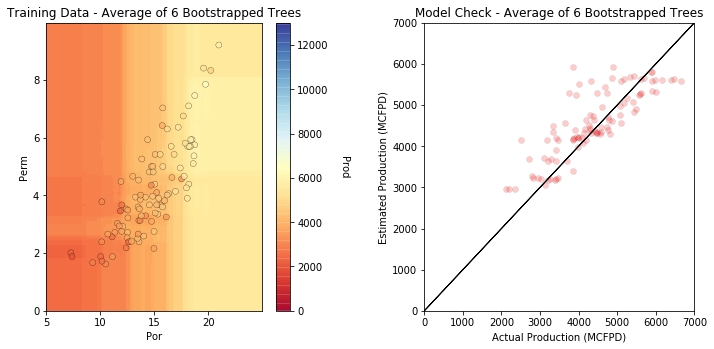

In [17]:
Z = pred[0] 
index = 1
for seed in seeds:                                          
    if index == 1:
        Z = pred[index-1]
    else:
        Z = Z + pred[index-1]                              
    index = index + 1

Z = Z / len(seeds)
    
plt.subplot(121)                                           
visualize_grid(Z,my_data_subset["Por"],pormin,pormax,my_data_subset["Perm"],permin,permax,my_data_subset["Prod"],prodmin,prodmax,'Training Data - Average of 6 Bootstrapped Trees')

plt.subplot(122)                                           
check_grid(Z,pormin,pormax,permin,permax,my_data_test_subset["Por"],my_data_test_subset["Perm"],my_data_test_subset["Prod"],'Model Check - Average of 6 Bootstrapped Trees')

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.5, top=1.0, wspace=0.4, hspace=0.2)

###  3.1.2 Bagging with Increasing Number of Trees
6 bagging tree regression models with increasing number of overly complicated (and likely overfit) trees averaged. The number of trees is set to be [1,3,5,10,15,50]

Complete of 6:  1,  2,  3,  4,  5,  6,  

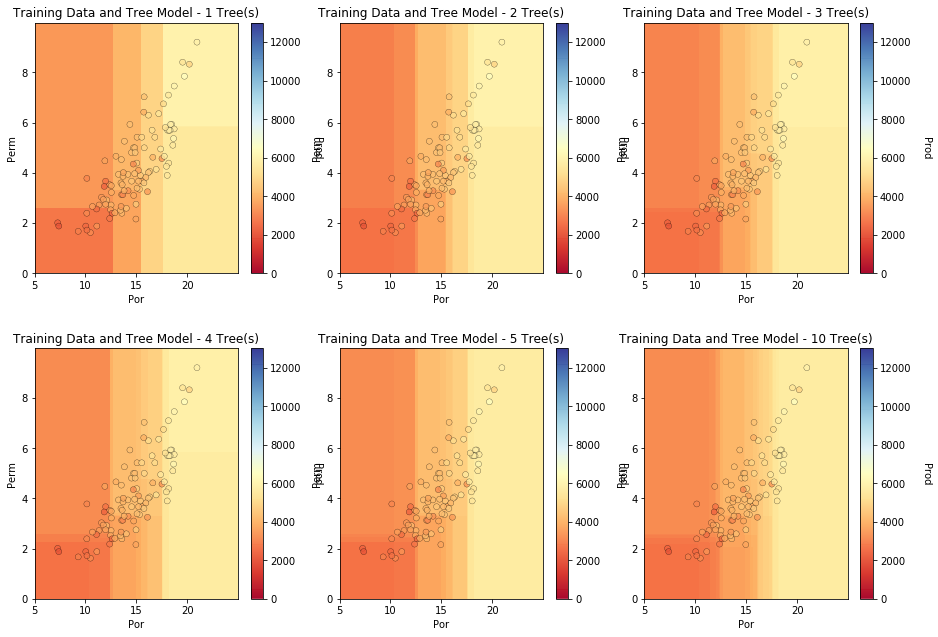

In [18]:
import warnings
warnings.filterwarnings('ignore')

max_depth = 3; min_samples_leaf = 5                        

regressor = DecisionTreeRegressor(max_depth = max_depth, min_samples_leaf = min_samples_leaf) 

seed = 73073;
num_trees = [1,2,3,4,5,10]                                
bagging_models_ntrees = []
oob_MSE = []
score = []

index = 1
print('Complete of ' + str(len(num_trees)) + ': ', end =" ")
for num_tree in num_trees:                                  
    bagging_models_ntrees.append(BaggingRegressor(base_estimator=regressor, n_estimators=num_tree, random_state=seed, oob_score = True, n_jobs = 4))
    bagging_models_ntrees[index-1].fit(X = predictors, y = response)
    oob_MSE.append(bagging_models_ntrees[index-1].oob_score_)
    score.append(bagging_models_ntrees[index-1].score(X = predictors_test, y = response_test))
    plt.subplot(2,3,index)
    visualize_model(bagging_models_ntrees[index-1],my_data_subset["Por"],pormin,pormax,my_data_subset["Perm"],permin,permax,my_data_subset["Prod"],prodmin,prodmax,'Training Data and Tree Model - ' + str(num_tree) + ' Tree(s)')
    print(str(index)+ ', ', end =" ")
    index = index + 1
    
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.0, wspace=0.2, hspace=0.3)

We can observe that we are getting a more continuous model as we increase the number of trees, cross validation is chechck

Mean Squared Error on Training =  366368.69 , Variance Explained = 0.68 Cor = 0.8
Mean Squared Error on Training =  333674.27 , Variance Explained = 0.68 Cor = 0.82
Mean Squared Error on Training =  325880.06 , Variance Explained = 0.69 Cor = 0.83
Mean Squared Error on Training =  333634.8 , Variance Explained = 0.68 Cor = 0.82
Mean Squared Error on Training =  337247.74 , Variance Explained = 0.67 Cor = 0.82
Mean Squared Error on Training =  311512.59 , Variance Explained = 0.7 Cor = 0.83


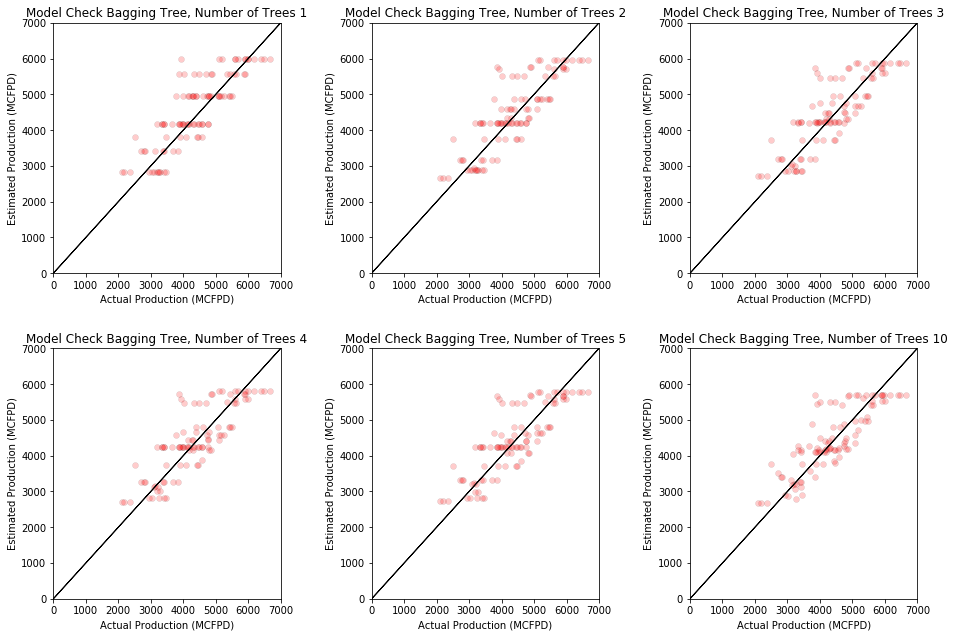

In [19]:
index = 1
for num_tree in num_trees:                                  # loop over number of trees
    plt.subplot(2,3,index)
    check_model(bagging_models_ntrees[index-1],my_data_test_subset["Por"],my_data_test_subset["Perm"],my_data_test_subset["Prod"],'Model Check Bagging Tree, Number of Trees ' + str(num_trees[index-1]))
    index = index + 1
    
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.0, wspace=0.4, hspace=0.3)

The prediction model is becoming more accurate as well increase the tree number. Mre variance is explained

### 3.2 Random Forest
In random forests , each tree in the ensemble is built from a sample drawn with replacement from the training set.

Mean Squared Error on Training =  309740.7 , Variance Explained = 0.71 Cor = 0.83


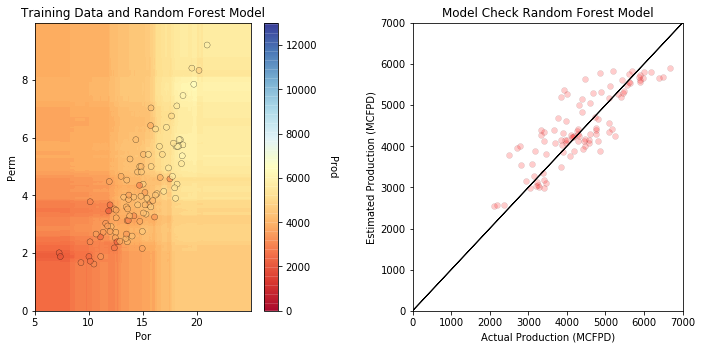

In [20]:
seed = 73093                                                
max_depth = 10
num_tree = 500
max_features = 1

big_forest = RandomForestRegressor(max_depth=max_depth, random_state=seed,n_estimators=num_tree, max_features=max_features, oob_score = True, n_jobs = 4)

big_forest.fit(X = predictors, y = response)

plt.subplot(121)                                            
visualize_model(big_forest,my_data_subset["Por"],pormin,pormax,my_data_subset["Perm"],permin,permax,my_data_subset["Prod"],prodmin,prodmax,'Training Data and Random Forest Model')

plt.subplot(122)                                            
check_model(big_forest,my_data_test_subset["Por"],my_data_test_subset["Perm"],my_data_test_subset["Prod"],'Model Check Random Forest Model')

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.5, top=1.0, wspace=0.4, hspace=0.2)

I limited  maximum depth = 1 and single tree in each forest at the first step so that I can see the divesity in the first splits over multiple models.

Complete of 6:  1,  2,  3,  4,  5,  6,  

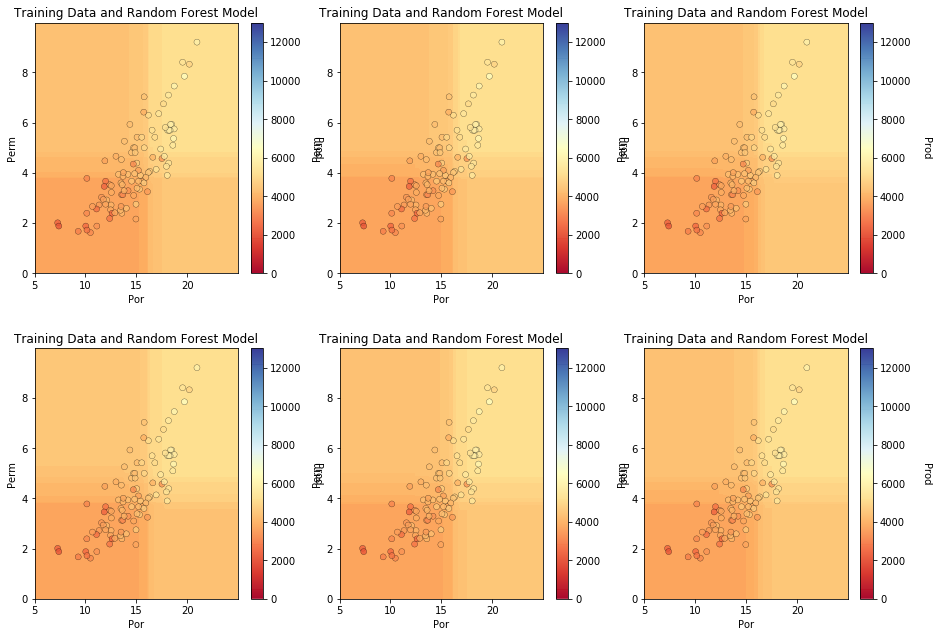

In [21]:
import warnings
warnings.filterwarnings('ignore')                           
                                  
max_depth = 1                                              
max_features = 1
simple_forest = []

seeds = [73103,73104,73105,73106,73107,73108]               

index = 1
print('Complete of ' + str(len(seeds)) + ': ', end =" ")
for seed in seeds:                                          
    simple_forest.append(RandomForestRegressor(max_depth=max_depth, random_state=seed,n_estimators=num_tree, max_features=max_features))
    simple_forest[index-1].fit(X = predictors, y = response)
    plt.subplot(2,3,index)                               
    visualize_model(simple_forest[index-1],my_data_subset["Por"],pormin,pormax,my_data_subset["Perm"],permin,permax,my_data_subset["Prod"],prodmin,prodmax,'Training Data and Random Forest Model')
    print(str(index)+ ', ', end =" ")
    index = index + 1
    
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.0, wspace=0.2, hspace=0.3)

 The first splits are 50/50 porosity and permeability, the variance and Covariance is very close to the Tree bagging method.  

### 3.3 Model Performance by Out-of-Bag and Feature Importance
More procedure is needed to check this model

Mean Squared Error on Training =  311357.72 , Variance Explained = 0.7 Cor = 0.83


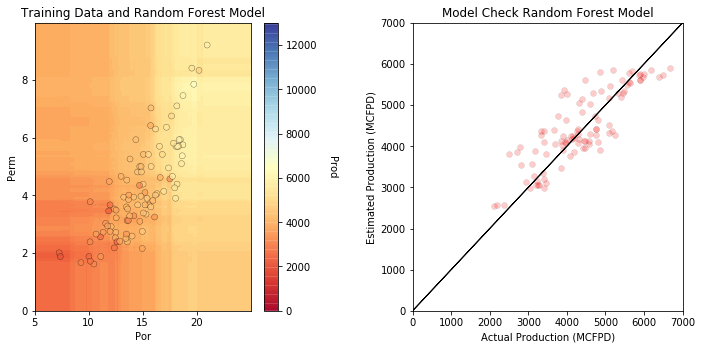

In [22]:
seed = 73093                                                
max_depth = 7
num_tree = 500
max_features = 1

big_forest = RandomForestRegressor(max_depth=max_depth, random_state=seed,n_estimators=num_tree, max_features=max_features, oob_score = True, n_jobs = 4)

big_forest.fit(X = predictors, y = response)

plt.subplot(121)                                            
visualize_model(big_forest,my_data_subset["Por"],pormin,pormax,my_data_subset["Perm"],permin,permax,my_data_subset["Prod"],prodmin,prodmax,'Training Data and Random Forest Model')

plt.subplot(122)                                            
check_model(big_forest,my_data_test_subset["Por"],my_data_test_subset["Perm"],my_data_test_subset["Prod"],'Model Check Random Forest Model')

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.5, top=1.0, wspace=0.4, hspace=0.2)

In [23]:
big_forest.feature_importances_

array([0.57639233, 0.42360767])

1. feature 0 (0.576392)
2. feature 1 (0.423608)


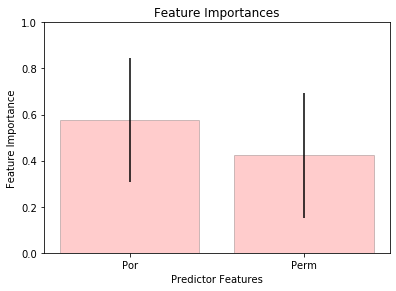

In [24]:
importances = big_forest.feature_importances_              
std = np.std([tree.feature_importances_ for tree in big_forest.estimators_],axis=0)
indices = np.argsort(importances)[::-1]

features = ['Por','Perm']                       

for f in range(len(features)):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

plt.subplot(111)
plt.title("Feature Importances")
plt.bar(features, importances[indices],color="red", alpha = 0.2, edgecolor = 'black', yerr=std[indices], align="center")
#plt.xticks(range(X.shape[1]), indices)
plt.ylim(0,1), plt.xlabel('Predictor Features'); plt.ylabel('Feature Importance')
plt.subplots_adjust(left=0.0, bottom=0.0, right=0.8, top=0.8, wspace=0.2, hspace=0.2)
plt.show()

Hyperparameter training with the out-of-bag mean square error is conducted

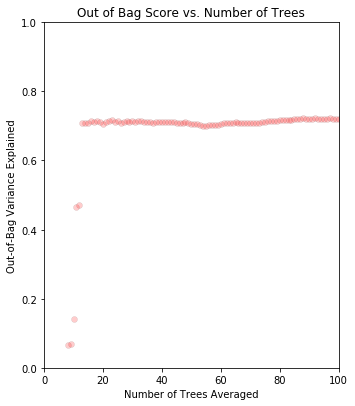

In [25]:
import warnings
warnings.filterwarnings('ignore')
                                  
max_depth = 5                                              
num_trees = np.linspace(1,100,100)
max_features = 1
fit_forests = []
oob_MSE = []

index = 1
for num_tree in num_trees:                                
    fit_forests.append(RandomForestRegressor(oob_score = True,max_depth=max_depth, random_state=seed,n_estimators=int(num_tree), max_features=max_features))
    fit_forests[index-1].fit(X = predictors, y = response)
    oob_MSE.append(fit_forests[index-1].oob_score_)
    index = index + 1
    
plt.subplot(121)
plt.scatter(num_trees,oob_MSE,s=None, c='red', marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.2, linewidths=0.3, verts=None, edgecolors="black")
plt.title('Out of Bag Score vs. Number of Trees'); plt.xlabel('Number of Trees Averaged'); plt.ylabel('Out-of-Bag Variance Explained')
plt.xlim(0,100); plt.ylim(0,1.0)

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.5, top=1.2, wspace=0.2, hspace=0.2)
plt.show()

It looks like we need a minimum at least 20 trees for best performance 

1,  2,  3,  4,  5,  6,  7,  8,  9,  10,  11,  12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  

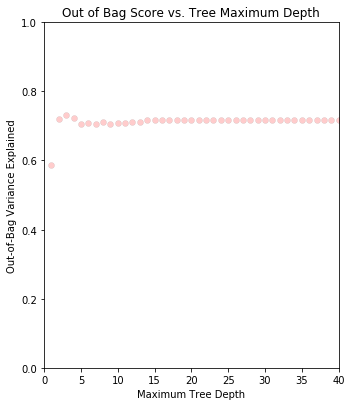

In [26]:
import warnings
warnings.filterwarnings('ignore')
                                  
max_depths = np.linspace(1,40,40)                          

num_tree = 60                                              
max_features = 1
fit_forests = []
oob_MSE = []

index = 1

for max_depth in max_depths:                              
    fit_forests.append(RandomForestRegressor(oob_score = True,max_depth=int(max_depth), random_state=seed,n_estimators=num_tree, max_features=max_features))
    fit_forests[index-1].fit(X = predictors, y = response)
    oob_MSE.append(fit_forests[index-1].oob_score_)
    print(str(index)+ ', ', end =" ")
    index = index + 1
    
plt.subplot(121)                                          
plt.scatter(max_depths,oob_MSE,s=None, c='red', marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.2, linewidths=0.3, verts=None, edgecolors="black")
plt.title('Out of Bag Score vs. Tree Maximum Depth'); plt.xlabel('Maximum Tree Depth'); plt.ylabel('Out-of-Bag Variance Explained')
plt.xlim(0,40); plt.ylim(0,1.0)

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.5, top=1.2, wspace=0.2, hspace=0.2)
plt.show()

It looks like we need a maximum tree depth of at least 5 splits for best performance of our model with respect to out-of-bag samples variance explained.

## Conclusion
In this project,we established  a  robust model with a large ensemble of trees for production rate regression. The conclusion are as follow:

* permeability and porosity are picked as predictor features for production rate based on feature ranking method. These two parameters are highly correlated in this reservoir and dorminant factor that controls the production rate. 
* VR is never considered to be a very influencial parameter in this reservoir
* TOC and AI are strongly negtively correlated. However, from partial correlated coefficient, TOC has no contribute for production rate
* Tree Bagging and Random Forest are both tested for this model, this performance of these two model are very close in this project.


